This file contains the necessary code to interactively explore the output of the model, and recreate the figures from the paper, using the best fit parameters obtained after running `parameter_estimation.py`.

Uncomment the `plt.savefig()` lines to overwrite the existing figures.

**Note:** this notebook was elaborated with Python 2.7 and the label generation requires LaTeX.

---

Row-wise subplot titles using phantom background plot adapted from [here](https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot).

In [36]:
# We import the necessary packages
from functions_global import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
plt.style.use('seaborn')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

In [37]:
# We load the raw data
dataRaw = pd.read_csv('../../data/VNA.csv')
timesData = dataRaw['days'].tolist() # List of time points
nMeasurements = 4

# We construct the arrays of data for each vaccine formulation
PBS = []  # Non-adjuvanted vaccine
MF59 = []  # Vaccine with MF59
AS03 = []  # Vaccine with AS03
Diluvac = []  #Vaccine with Diluvac
X_data = [] # List of (repeated) time points

for i in range(len(timesData)):
    for j in range(1,nMeasurements+1):
        X_data.append(timesData[i])
        PBS.append(dataRaw.T.iloc[j][i])
    for j in range(nMeasurements+1,2*nMeasurements+1):
        MF59.append(dataRaw.T.iloc[j][i])
    for j in range(2*nMeasurements+1,3*nMeasurements+1):
        AS03.append(dataRaw.T.iloc[j][i])
    for j in range(3*nMeasurements+1,4*nMeasurements+1):
        Diluvac.append(dataRaw.T.iloc[j][i])
X_data = np.array(X_data)
PBS = np.array(PBS)
MF59 = np.array(MF59)
AS03 = np.array(AS03)
Diluvac = np.array(Diluvac)
y_data = [PBS, MF59, AS03, Diluvac]

In [38]:
# We load the best fit parameters
params_base = pd.Series.from_csv('../../params/best_fit_params_base_A.csv')
params_adj = pd.read_csv('../../params/best_fit_params_adj_A.csv', index_col=0).set_index('adjuvant')
gammaNA, gammaHA, mu, dmax = params_base['gammaNA'], params_base['gammaHA'], params_base['mu'], params_base['dmax']

adjuvants = params_adj.index.get_values()
betaNA_list = []
betaHA_list = []
betaAb_list = []
for adj in adjuvants:
    betaNA_list.append(params_adj.loc[adj]['betaNA'])
    betaHA_list.append(params_adj.loc[adj]['betaHA'])
    betaAb_list.append(params_adj.loc[adj]['betaAb'])

In [39]:
# We integrate the PDEs for each vaccine formulation
X_model = np.arange(0, timeStop + dt, 1.0)
model_output = []
total_Ab = []

# Base
baseQ = vQ0(np.abs(grid), dmax) + vQ0(np.abs(1 - grid), dmax)
H = Htilde*0.5*(np.sign(grid - 0.99*dmax) + np.sign(1.0 - 0.99*dmax - grid))
Q_PBS = gammaNA*vQ0(abs(grid), dmax) + gammaHA*vQ0(abs(1 - grid), dmax)
y0 = np.zeros(2*Nx)
y0[1 :: 2] = np.ones(Nx)
sol_PBS = odeint(affinityMaturation, y0, t, args=(t_boost, H, baseQ, Q_PBS, ktilde, mu, dx), ml=2, mu=2)
model_output.append(sol_PBS)
total_Ab.append(np.array([np.sum(sol_PBS[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model]))

# Adjuvants
for i in range(len(adjuvants)):
    Q_adj = (gammaNA*betaNA_list[i]*vQ0(np.abs(grid), dmax) + gammaHA*betaHA_list[i]*vQ0(np.abs(1 - grid), dmax))
    y0 = np.zeros(2*Nx)
    y0[1 :: 2] = np.ones(Nx)
    sol_adj = odeint(affinityMaturation, y0, t, args=(t_boost, H, baseQ, Q_adj, ktilde*betaAb_list[i], mu, dx), ml=2, mu=2)
    model_output.append(sol_adj)
    total_Ab.append(np.array([np.sum(sol_adj[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model]))

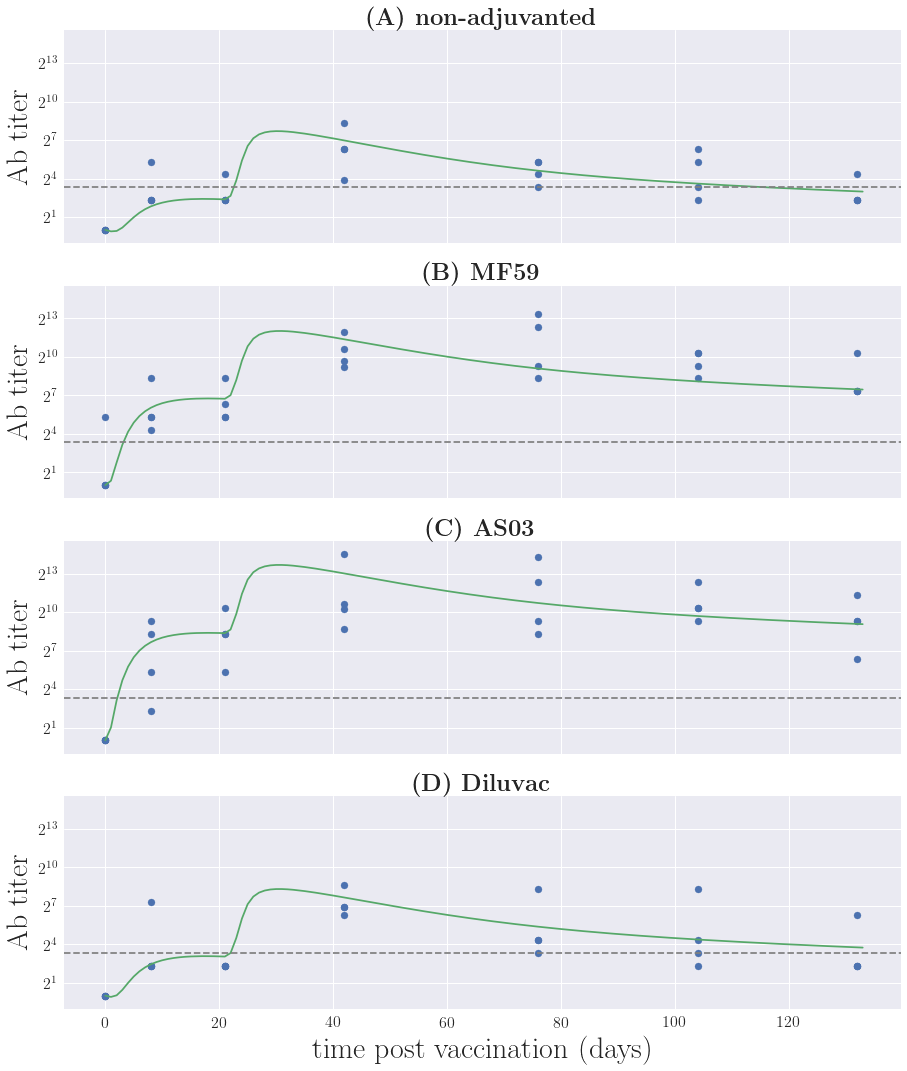

In [40]:
# We plot the data and the model output for every case

# These two lines create a list containing the default colour cycle in the style
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

f, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(15,18))
config = np.append(['non-adjuvanted'],adjuvants)
figlabels = [r'\bf{(A)} ', r'\bf{(B)} ', r'\bf{(C)} ', r'\bf{(D)} ']
axes[3].set_xlabel('time post vaccination (days)', fontsize=30)
for i in range(4):
    axes[i].tick_params(labelsize=16)
    axes[i].set_ylabel('Ab titer', fontsize=30)
    axes[i].set_yscale('log', basey=2)
    axes[i].set_title(figlabels[i]+config[i],fontsize=24)
    axes[i].scatter(X_data, y_data[i])
    axes[i].plot(X_model, total_Ab[i],color=colours[1])
    axes[i].axhline(y=10,color='grey',linestyle='--')

# Uncomment line below to save a new version of the figure
# plt.savefig('../../figures/fig2_Ab_vs_t.pdf',bbox_inches='tight')

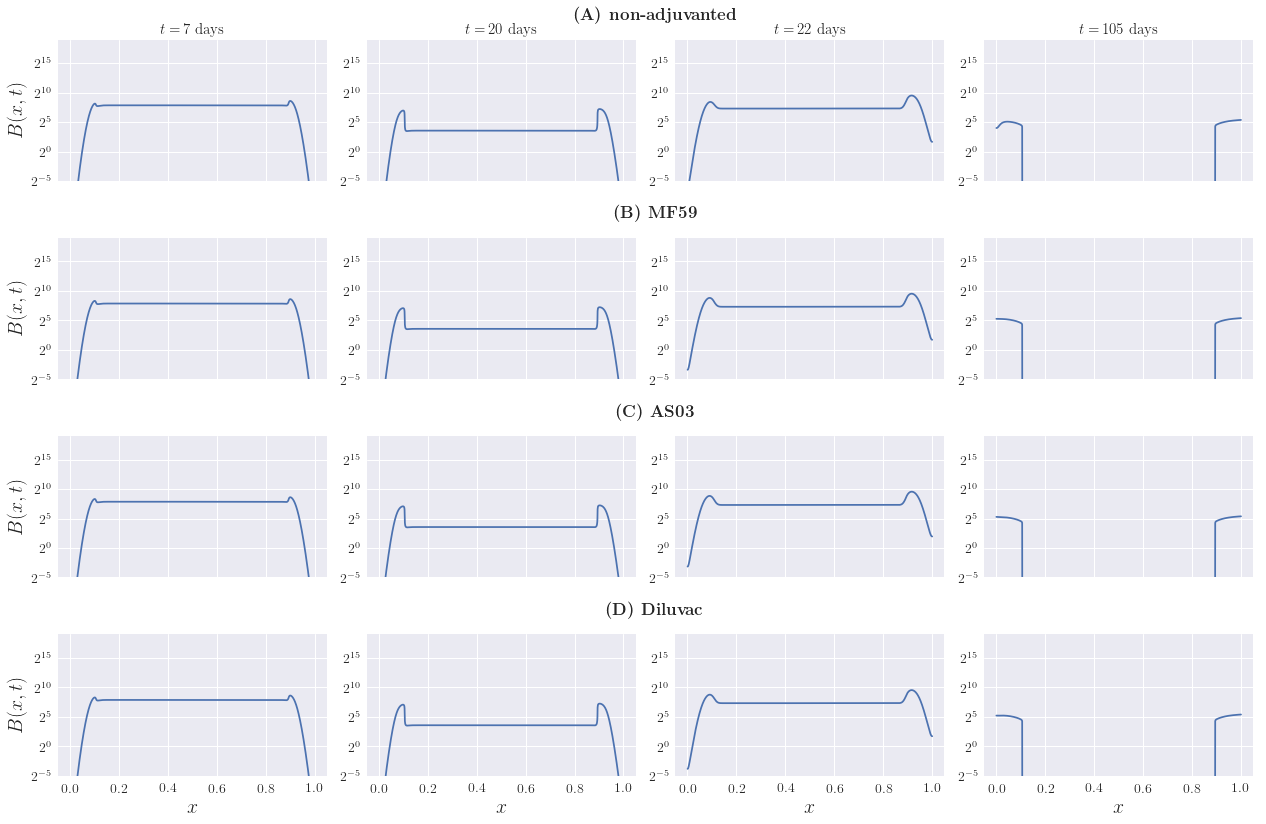

In [41]:
# Now the profiles of B(x) and Ab(x) at selected times
timeSnapshot = [7, 20, 22, 105]

f, big_axes = plt.subplots(4,1, sharex=True, sharey=True, figsize=(18,12))

for row, big_ax in enumerate(big_axes):
    big_ax.set_title(figlabels[row]+config[row], fontsize=17, x=0.5, y=1.1)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
axes = [[f.add_subplot(4,4,i) for i in range(4*j+1,4*(j+1)+1)] for j in range(4)]    
for i in range(len(model_output)):
    axes[i][0].set_ylabel('$B(x,t)$', fontsize=20)
    for j in range(len(timeSnapshot)):
        axes[0][j].set_xticklabels([])
        axes[1][j].set_xticklabels([])
        axes[2][j].set_xticklabels([])
        axes[i][j].set_yscale('log', basey=2)
        axes[i][j].set_ylim(2**(-5), 2**19)
        axes[0][j].set_title('$t=\,$'+str(timeSnapshot[j])+' days',fontsize=15)
        axes[i][j].tick_params(labelsize=14)
        axes[3][j].set_xlabel('$x$', fontsize=20)
        axes[i][j].plot(grid,model_output[i][np.argwhere(t == timeSnapshot[j])[0][0]][::2])
plt.tight_layout()

# Uncomment line below to save a new version of the figure
# plt.savefig('../../figures/fig3_snapshots_B.pdf')

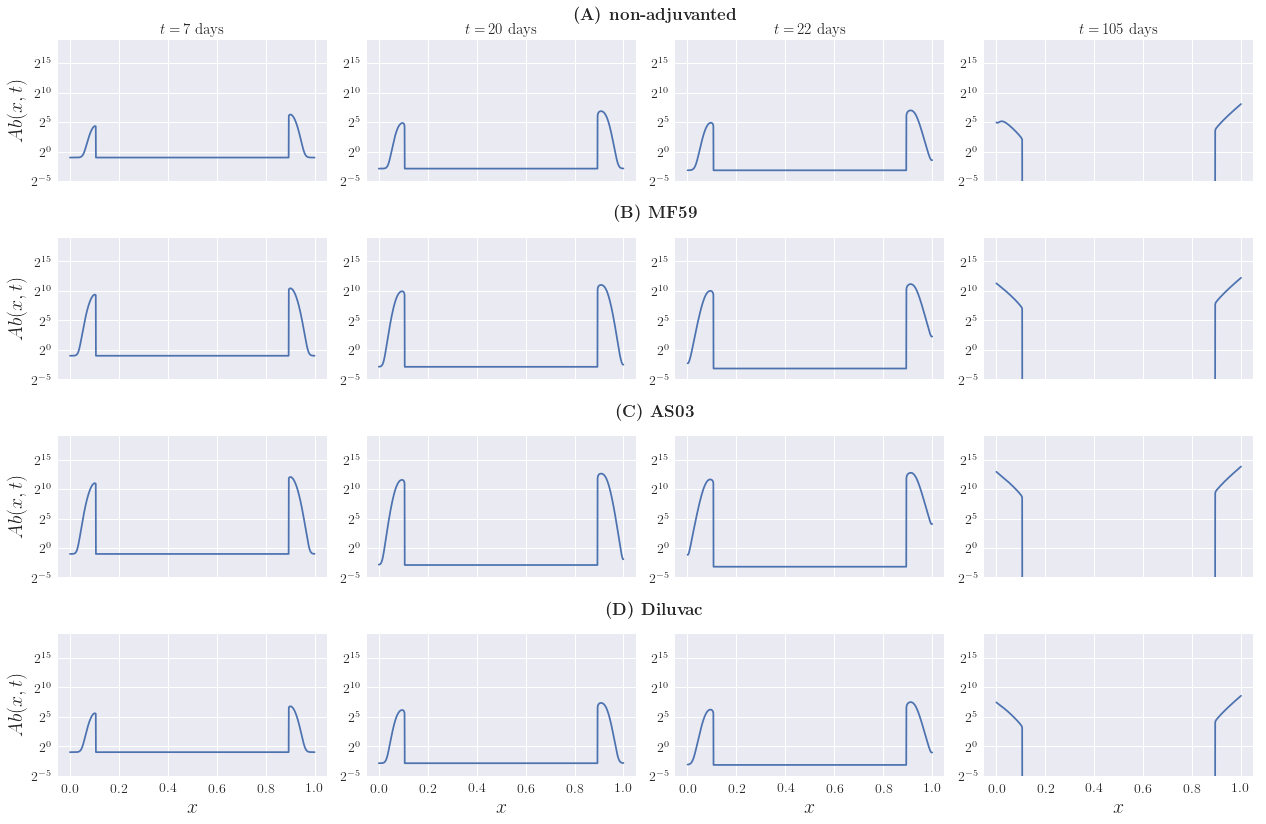

In [42]:
f, big_axes = plt.subplots(4,1, sharex=True, sharey=True, figsize=(18,12))

for row, big_ax in enumerate(big_axes):
    big_ax.set_title(figlabels[row]+config[row], fontsize=17, x=0.5, y=1.1)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
axes = [[f.add_subplot(4,4,i) for i in range(4*j+1,4*(j+1)+1)] for j in range(4)]    
for i in range(len(model_output)):
    axes[i][0].set_ylabel('$Ab(x,t)$', fontsize=20)
    for j in range(len(timeSnapshot)):
        axes[0][j].set_xticklabels([])
        axes[1][j].set_xticklabels([])
        axes[2][j].set_xticklabels([])
        axes[i][j].set_yscale('log', basey=2)
        axes[i][j].set_ylim(2**(-5), 2**19)
        axes[0][j].set_title('$t=\,$'+str(timeSnapshot[j])+' days',fontsize=15)
        axes[i][j].tick_params(labelsize=14)
        axes[3][j].set_xlabel('$x$', fontsize=20)
        axes[i][j].plot(grid,model_output[i][np.argwhere(t == timeSnapshot[j])[0][0]][1::2])
plt.tight_layout()

# Uncomment line below to save a new version of the figure
# plt.savefig('../../figures/fig4_snapshots_Ab.pdf')

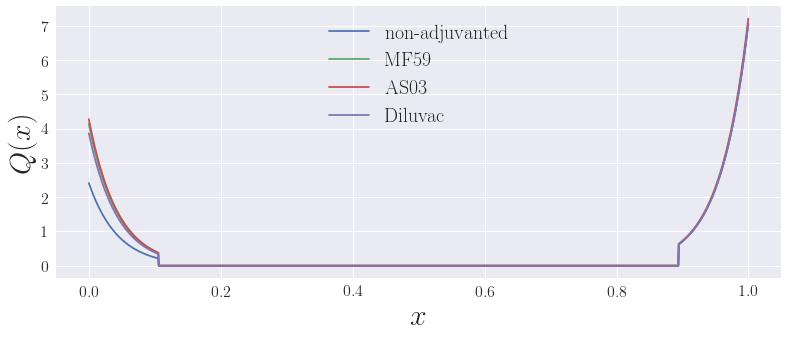

In [43]:
# Weighted binding affinity
f, ax = plt.subplots(figsize=(13,5))
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$x$', fontsize=30)
ax.set_ylabel(r'$Q(x)$', fontsize=30)
ax.plot(grid, Q_PBS, label='non-adjuvanted')
for i in range(len(adjuvants)):
    Q_adj = (gammaNA*betaNA_list[i]*vQ0(np.abs(grid), dmax) + gammaHA*betaHA_list[i]*vQ0(np.abs(1 - grid), dmax))
    ax.plot(grid, Q_adj, label=adjuvants[i])
    ax.legend(prop={'size': 20})
    
# Uncomment line below to save a new version of the figure
# plt.savefig('../../figures/fig5_Q_vs_x.pdf',bbox_inches='tight')

In [44]:
# Protein-specific Abs from the model
Ab_NA = []
Ab_HA = []

cutoff = int(dmax*len(sol_PBS[0]))
if cutoff%2==0:
    cutoff+=1

# Base
Ab_NA.append(np.array([np.sum(model_output[0][np.argwhere(t == z)[0][0]][1 : cutoff : 2])*dx for z in X_model]))
Ab_HA.append(np.array([np.sum(model_output[0][np.argwhere(t == z)[0][0]][2*len(grid)-cutoff :: 2])*dx for z in X_model]))

# Adjuvants
for i in range(len(adjuvants)):
    Q_adj = (gammaNA*betaNA_list[i]*vQ0(np.abs(grid), dmax) + gammaHA*betaHA_list[i]*vQ0(np.abs(1 - grid), dmax))
    y0 = np.zeros(2*Nx)
    y0[1 :: 2] = np.ones(Nx)
    Ab_NA.append(np.array([np.sum(model_output[i+1][np.argwhere(t == z)[0][0]][1 : cutoff : 2])*dx for z in X_model]))
    Ab_HA.append(np.array([np.sum(model_output[i+1][np.argwhere(t == z)[0][0]][2*len(grid)-cutoff :: 2])*dx for z in X_model]))

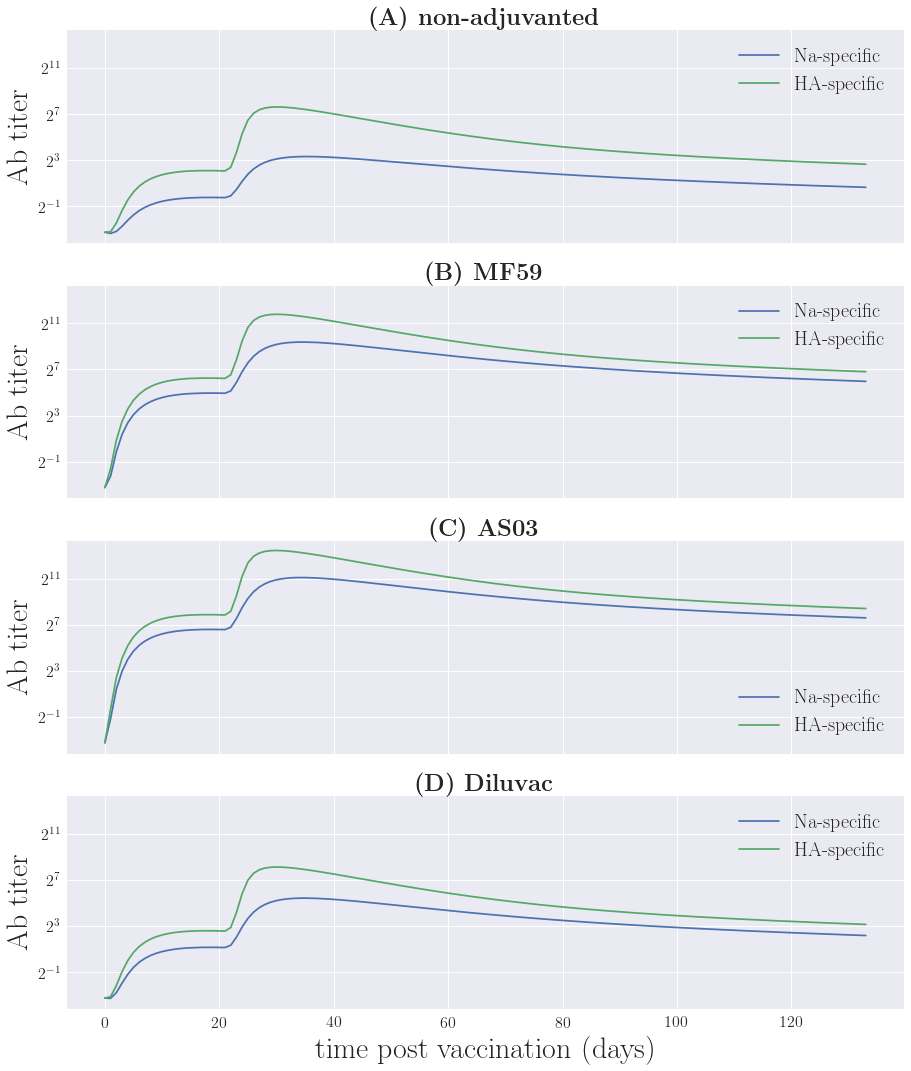

In [45]:
f, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(15,18))
figlabels = [r'\bf{(A)} ', r'\bf{(B)} ', r'\bf{(C)} ', r'\bf{(D)} ']
axes[3].set_xlabel('time post vaccination (days)', fontsize=30)
for i in range(4):
    axes[i].tick_params(labelsize=16)
    axes[i].set_ylabel('Ab titer', fontsize=30)
    axes[i].set_yscale('log', basey=2)
    axes[i].set_title(figlabels[i]+config[i],fontsize=24)
    axes[i].plot(X_model, Ab_NA[i], label='Na-specific')
    axes[i].plot(X_model, Ab_HA[i], label='HA-specific')
    axes[i].legend(prop={'size': 20})
    
# Uncomment line below to save a new version of the figure
# plt.savefig('../../figures/fig6_Ab_specific_vs_t.pdf',bbox_inches='tight')

In [46]:
# Visualising best fit parameters
params_base=params_base.rename('non-adjuvanted')
params_all=params_adj.append(params_base)
params_all.index.names = ['formulation']
params_all = params_all.reindex(config)
params_all = params_all.fillna('-')
params_all

,betaAb,betaHA,betaNA,dmax,gammaHA,gammaNA,mu
formulation,,,,,,,
non-adjuvanted,-,-,-,0.105761,7.09991,2.43451,0.46016
MF59,17.6365,1.00387,1.71237,-,-,-,-
AS03,52.2757,1.02388,1.77161,-,-,-,-
Diluvac,1.39362,1.00314,1.59981,-,-,-,-


In [47]:
# We load the raw data for the (total) protein-specific Ab
dataSpecific = pd.read_csv('../../data/total_NAHA.csv', index_col=0)

In [48]:
N1H1_PBS=dataSpecific['N1 (H1N1) PBS'].values
N1H1_MF59=dataSpecific['N1 (H1N1) MF59'].values
N1H1_AS03=dataSpecific['N1 (H1N1) AS03'].values
N1H1_Diluvac=dataSpecific['N1 (H1N1) Diluvac'].values
N1H5_PBS=dataSpecific['N1 (H5N1) PBS'].values
N1H5_MF59=dataSpecific['N1 (H5N1) MF59'].values
N1H5_AS03=dataSpecific['N1 (H5N1) AS03'].values
N1H5_Diluvac=dataSpecific['N1 (H5N1) Diluvac'].values
H1_PBS=dataSpecific['H1 (H1N1) PBS'].values
H1_MF59=dataSpecific['H1 (H1N1) MF59'].values
H1_AS03=dataSpecific['H1 (H1N1) AS03'].values
H1_Diluvac=dataSpecific['H1 (H1N1) Diluvac'].values
X_N1H1=2*np.ones_like(N1H1_PBS)
X_N1H5=3*np.ones_like(N1H1_PBS)
X_H1=np.ones_like(N1H1_PBS)
all_H1 = [[H1_PBS, H1_MF59], [H1_AS03, H1_Diluvac]]
all_N1H1 = [[N1H1_PBS, N1H1_MF59], [N1H1_AS03, N1H1_Diluvac]]
all_N1H5 = [[N1H5_PBS, N1H5_MF59], [N1H5_AS03, N1H5_Diluvac]]

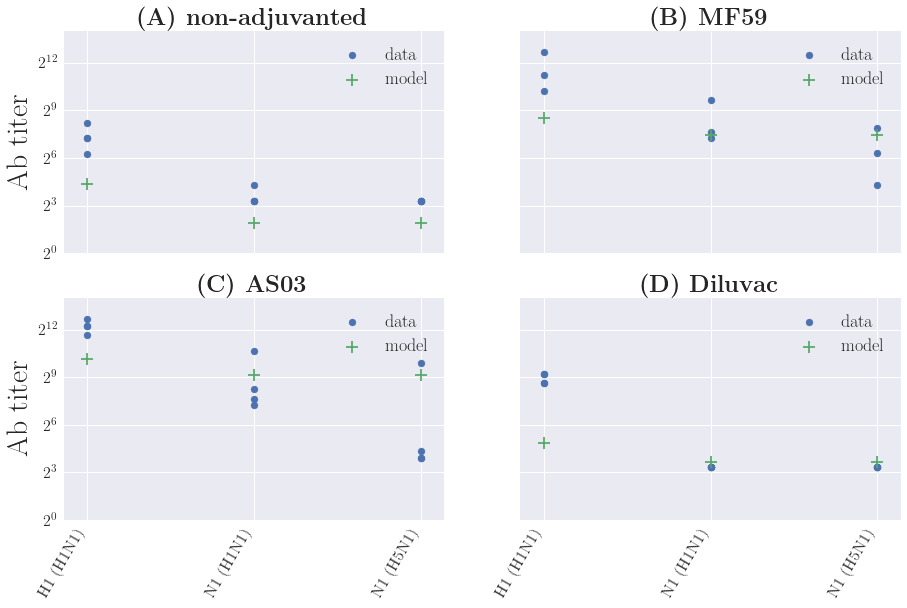

In [49]:
f, axes = plt.subplots(2, 2, figsize=(15,9), sharex=True, sharey=True)
axes[0][0].set_ylabel('Ab titer', fontsize=30)
axes[0][0].set_yscale('log', basey=2)
axes[1][0].set_ylabel('Ab titer', fontsize=30)
axes[0][0].set_ylim(1,2**14)
axes[1][0].set_xticks([1,2,3])
axes[1][1].set_xticks([1,2,3])
axes[1][0].set_xticklabels(['H1 (H1N1)', 'N1 (H1N1)', 'N1 (H5N1)'], rotation=60, ha='right')
axes[1][1].set_xticklabels(['H1 (H1N1)', 'N1 (H1N1)', 'N1 (H5N1)'], rotation=60, ha='right')
for i in range(2):
    for j in range(2):
        axes[i][j].set_title(figlabels[2*i+j]+config[2*i+j],fontsize=24)
        axes[i][j].tick_params(labelsize=16)
        axes[i][j].scatter(X_H1,all_H1[i][j], c=colours[0], label='data')
        axes[i][j].scatter([1.0], [Ab_HA[2*i+j][76]], c=colours[1], marker='+', s=[150], label='model')
        axes[i][j].scatter(X_N1H1,all_N1H1[i][j], c=colours[0])
        axes[i][j].scatter([2.0], [Ab_NA[2*i+j][76]], c=colours[1], marker='+', s=[150])
        axes[i][j].scatter(X_N1H5,all_N1H5[i][j], c=colours[0])
        axes[i][j].scatter([3.0], [Ab_NA[2*i+j][76]], c=colours[1], marker='+', s=[150])
        axes[i][j].legend(prop={'size': 18})
        
# Uncomment line below to save a new version of the figure
# plt.savefig('../../figures/fig7_proteinSpecific_total.pdf',bbox_inches='tight')

In [50]:
# We integrate the PDEs for each vaccine formulation with different intervals between doses
timeEnd = 450.0
X_model_2 = np.arange(0, timeEnd + dt, 1.0)
t = np.arange(0, timeEnd + dt, dt)
boostSweep_noadj = []
boostSweep_MF59 = []
boostSweep_AS03 = []
boostSweep_Diluvac = []

boostTimes = 7*np.arange(3.0, 22.0, 3.0)

baseQ = vQ0(np.abs(grid), dmax) + vQ0(np.abs(1 - grid), dmax)
H = Htilde*0.5*(np.sign(grid - 0.99*dmax) + np.sign(1.0 - 0.99*dmax - grid))
Q_PBS = gammaNA*vQ0(abs(grid), dmax) + gammaHA*vQ0(abs(1 - grid), dmax)
Q_MF59 = (gammaNA*betaNA_list[0]*vQ0(np.abs(grid), dmax) + gammaHA*betaHA_list[0]*vQ0(np.abs(1 - grid), dmax))
Q_AS03 = (gammaNA*betaNA_list[1]*vQ0(np.abs(grid), dmax) + gammaHA*betaHA_list[1]*vQ0(np.abs(1 - grid), dmax))
Q_Diluvac = (gammaNA*betaNA_list[2]*vQ0(np.abs(grid), dmax) + gammaHA*betaHA_list[2]*vQ0(np.abs(1 - grid), dmax))
for times in boostTimes:
    y0 = np.zeros(2*Nx)
    y0[1 :: 2] = np.ones(Nx)
    sol_PBS = odeint(affinityMaturation, y0, t, args=(times, H, baseQ, Q_PBS, ktilde, mu, dx), ml=2, mu=2)
    boostSweep_noadj.append(np.array([np.sum(sol_PBS[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model_2]))
    y0 = np.zeros(2*Nx)
    y0[1 :: 2] = np.ones(Nx)
    sol_adj = odeint(affinityMaturation, y0, t, args=(times, H, baseQ, Q_MF59, ktilde*betaAb_list[0], mu, dx), ml=2, mu=2)
    boostSweep_MF59.append(np.array([np.sum(sol_adj[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model_2]))
    y0 = np.zeros(2*Nx)
    y0[1 :: 2] = np.ones(Nx)
    sol_adj = odeint(affinityMaturation, y0, t, args=(times, H, baseQ, Q_AS03, ktilde*betaAb_list[1], mu, dx), ml=2, mu=2)
    boostSweep_AS03.append(np.array([np.sum(sol_adj[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model_2]))
    y0 = np.zeros(2*Nx)
    y0[1 :: 2] = np.ones(Nx)
    sol_adj = odeint(affinityMaturation, y0, t, args=(times, H, baseQ, Q_Diluvac, ktilde*betaAb_list[2], mu, dx), ml=2, mu=2)
    boostSweep_Diluvac.append(np.array([np.sum(sol_adj[np.argwhere(t == z)[0][0]][1 :: 2])*dx for z in X_model_2]))

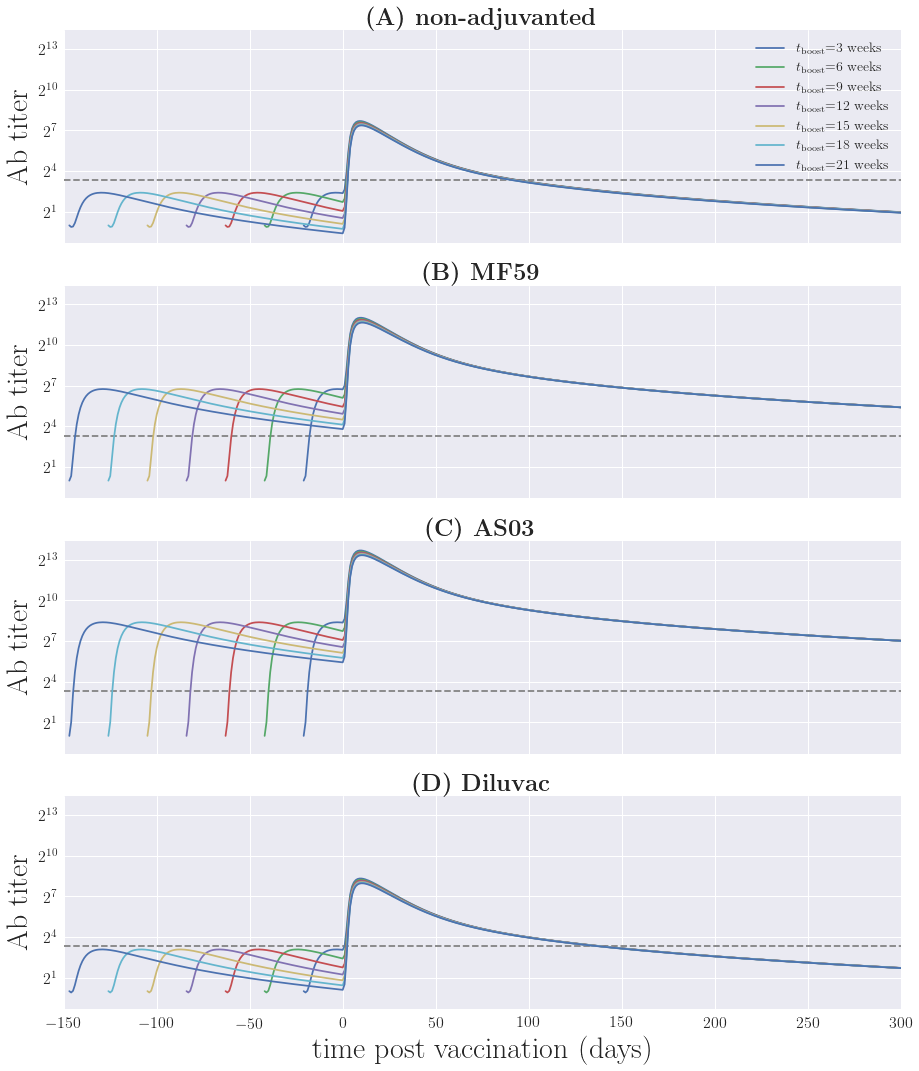

In [51]:
f, axes = plt.subplots(4,figsize=(15,18),sharex=True,sharey=True)
for i in range(4):
    axes[i].tick_params(labelsize=16)
    axes[i].set_ylabel('Ab titer', fontsize=30)
    axes[i].set_yscale('log', basey=2)
    axes[i].axhline(y=10,color='grey',linestyle='--')
    axes[i].set_xlim(-150,300)
    axes[i].set_title(figlabels[i]+config[i],fontsize=24)
axes[3].set_xlabel('time post vaccination (days)', fontsize=30)
for i in range(len(boostTimes)):
    axes[0].plot(X_model_2-boostTimes[i], boostSweep_noadj[i], label=r'$t_{\rm boost}$='+str(int(boostTimes[i]/7))+' weeks')
    axes[1].plot(X_model_2-boostTimes[i], boostSweep_MF59[i])
    axes[2].plot(X_model_2-boostTimes[i], boostSweep_AS03[i])
    axes[3].plot(X_model_2-boostTimes[i], boostSweep_Diluvac[i])
axes[0].legend(prop={'size': 14})

# Uncomment line below to save a new version of the figure
# plt.savefig('../../figures/fig8_boostSweep.pdf',bbox_inches='tight')